# Lab Activity 4.2. Clustering Algorithms without sklearn (KMeans and MinimBatch KMeans)
In this activity, we will implement K-means algorithm from scratch. You will be able to see first-hand how the algorithm is built in a simple and effective way. There are other implementations, we have chosen this one to expose the inner mechanisms and principles of clustering algorithms.

**Learning Outcomes**
1. Implement K-means algorithms and its variant from scratch using numpy
2. Understand the details of writing an algorithm gradually in a step by step manner
3. Understand how each step of K-means contributes to a convergence behaviour


# K-Means for Binary Clusters

In [1]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML('<style>.container {width: 85% !important}</style>'))

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.random import multivariate_normal as mnormal
import pandas as pd
import numpy as np

## Generate the Data
Below we create our own data generation routine which is sufficient for the study that we will conduct. There is a set of sklearn readymade datasets for clustering that can be utilized, such as make_moon(), make_bicluster() etc., see [datasets](https://scikit-learn.org/stable/modules/classes.html#samples-generator) and see also [clustering comparison](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html). The idea here to completely depend on numpy in all aspects of the activity.

In [3]:
# generate the data
def generatC12(N1=50, N2=50, spread1=2, spread2=3, shuffle=True):
    # sampling from two circles with different centers
    mu1, cov1 = [5, 5], [[.5*spread1, 0], [0, .5*spread1]]
    mu2, cov2 = [9, 5], [[.5*spread2, 0], [0, .5*spread2]]

    C1 = np.round(mnormal(mu1, cov1, N1), 1)  # Cluster 1 in 2d
    C2 = np.round(mnormal(mu2, cov2, N2), 1)  # Cluster 2 in 2d
    C12 = np.concatenate((C1,C2), axis=0)     # combine both clusters, no labels are provided (unsupervised learning)
    if shuffle: np.random.default_rng().shuffle(C12)      # this is to mix up the two clusters so that batching makes more sense
    
    c1 = np.mean(C1,0)        # centroid of C1
    c2 = np.mean(C2,0)        # centroid of C2
    
    return C12, c1, c2, C1, C2  # the generated data put pairs on the columns to make plotting easy


Note that we do not use labels here and we return the clusters separately for pedagogical reasons to make a notional distinction between unsupervised and supervised learning. However you can amend the implementation to use labels instead of returning the different clusters separately.

## Helper Functions

In [4]:
def plotC(C, colourshape='bo', c=None):
    C = C.T
    plt.plot(C[0], C[1], colourshape, markersize=10, mfc='none')
    if c is not None: 
        plt.plot(c[0], c[1],  '+', markersize=25)

def plotC12(C1, C2, c1, c2):
    plotC(C1, 'g^', c1)
    plotC(C2, 'yo', c2)

def saveC(C):
    #save in panda dataframe
    Cf = pd.DataFrame(C,columns=['x1','x2'])     # we want the data to be tabular   
    Cf.to_csv  ('datasets/SimpleBinaryClusters.csv', index=False)
    plt.savefig('figures/SimpleBinaryClusters.png')

In [5]:
# now we calculate the distance between each centroid and the rest of the dataset, 
# we can use broadcasting which is great to guarantee efficiency of running the algorithm
# c1_ ,  c2_ = c1 - 1.5,  c2 + 2.5
# c1_ ,  c2_ = c1 + 1.5,  c2 - 2.5

def getClusters(C12, c1, c2, plot=True):
    
    dist1 = np.sqrt(np.sum((c1 - C12)**2,1))   # note how we utilise broadcasting
    dist2 = np.sqrt(np.sum((c2 - C12)**2,1))   # note how we utilise broadcasting
    min_dist = np.minimum(dist1,dist2)         # this returns an array of min distances
    
    C1_ind = np.where(dist1==min_dist)
    C2_ind = np.where(dist2==min_dist)

    C1 = C12[C1_ind]
    C2 = C12[C2_ind]

    if plot:
        plotC(C1, 'k^', c1)
        plotC(C2, 'yo', c2)    
    
    return C1, C2

## Retrieve the Centroids

In [6]:
def getCentroids(C1, C2):
    
    c1 = np.mean(C1,0)        # centroid of C1
    c2 = np.mean(C2,0)        # centroid of C2
    
    return c1, c2

## Implement K-means
Now we are in a position to be able to implement the K-means algorithm:

In [7]:
def kmeans(C12, c1=None, c2=None, save=False):
    if c1 is None: c1 = C12.mean(0) + 2*C12.std(0)
    if c2 is None: c2 = C12.mean(0) - 2*C12.std(0)
    #while True:
    for i in range(100):
        C1,  C2  = getClusters (C12, c1, c2) # first  for loop of K-means algorithm
        c1_, c2_ = getCentroids(C1,  C2)     # second for loop of K-means algorithm

        if save==True: 
            plt.savefig('figures/SimpleBinaryClusters{}.png'.format(i))
            
        if (c1_==c1).all() and (c2_==c2).all(): 
            print('clusters stabilised'); break   # early stopping condition
        else: c1, c2 = c1_, c2_
        
        plt.pause(.1) # comment this out in order to make the algorihtm fast, it is placed to visualise different steps
        clear_output(wait=True)
        plt.show()
        
    return c1, c2

(1000, 2)


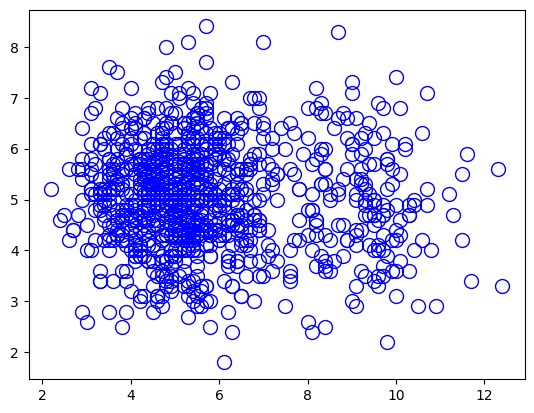

In [8]:
#C1__, C2__, c1__, c2__, C12__ = C1, C2, c1, c2, C12   # to store a  instance that we like
C12, c1, c2, C1, C2 = generatC12(N1=800,N2=200)                    # uncoment to regenerate
print(C12.shape)
# plotC12(C1, C2, c1+0.7, c2-0.7 )
plotC(C12)
saveC(C12)

Usually, we are presented with the above dataset without knowing the clusters beforehand. Then our task is to find a suitable clusters based on the dataset inner characteristics and distances or similarity between the data points.

Let us plot the clusters using the priori knowledge that we have about the clusters. Note that this is not available for us in a real world data and we are plotting it to compare between the desired solution and the solution provided by our clustering algorithms.

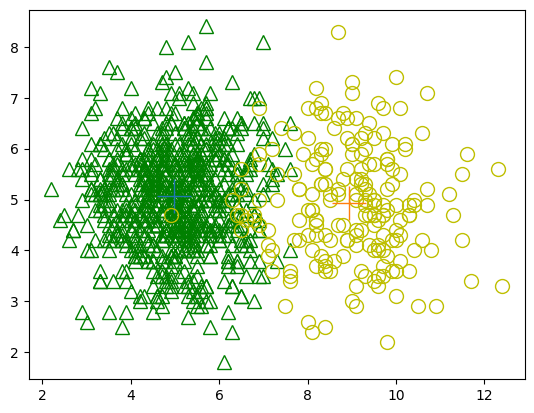

In [9]:
plotC12(C1, C2, c1, c2)
plt.savefig('figures/SimpleBinaryClustersSolution.png')

## Apply K-means
Ok, now it is time to apply our K-means algorithm and see how it perform on this synthetic dataset.

clusters stabilised
[4.9752809  5.07116105] [9.00452261 4.94170854]


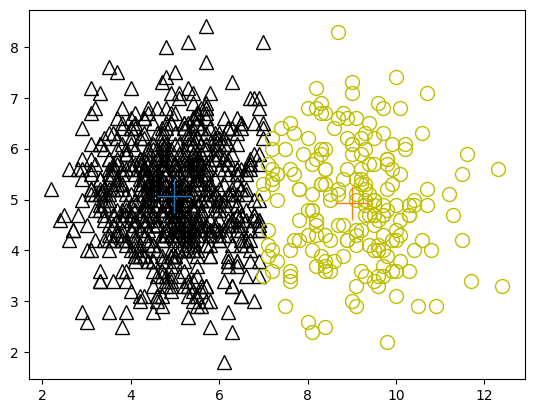

In [10]:
#c1, c2 = [6,3], [1,10]  # try this and se how this centroid initialisation can lead to infinitely loop we address this problem in k-means++
#c1, c2 = [6,2], [1,10]  # also does not work

c1, c2 = [6,1], [1,10]
cnt1, cnt2 = kmeans(C12, c2, c1 )
print(cnt1, cnt2)

clusters stabilised


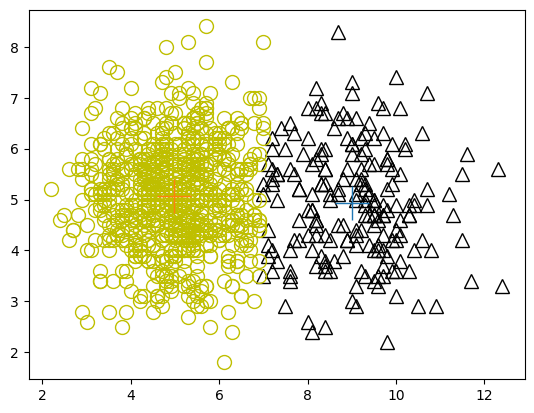

In [11]:
cnt1, cnt2 = kmeans(C12)

### Your Turn: Mini-Batch K-means

Now it is we turn to implementing the mini-batch K-means. It is almost identical to the K-means, the main difference is that we partition the dataset into several chunks with the same size and then we use one after the other to update the centroids and the clusters. Refer to the algorithm in Minerva.

In [12]:
# simple non conformant implementation
def kmeansMB_naive(C12_, c1=None, c2=None, mb=5):
    if c1 is None: c1 = C12.mean(0) + 2*C12.std(0)
    if c2 is None: c2 = C12.mean(0) - 2*C12.std(0)
    mb_size = C12_.shape[0]//mb
    
    for b in range(mb):
        
        # take a mini-batch, 
        # this implementation is not the standard as it increases the batch size slowly instead of isolating a batch        
        C12 = C12_[:(b+1)*mb_size,:]
        
        for i in range(10):
            C1, C2 = getClusters (C12, c1, c2)
            c1, c2 = getCentroids(C1,  C2)
              
            plt.pause(.1)
            clear_output(wait=True)
            plt.show()
            

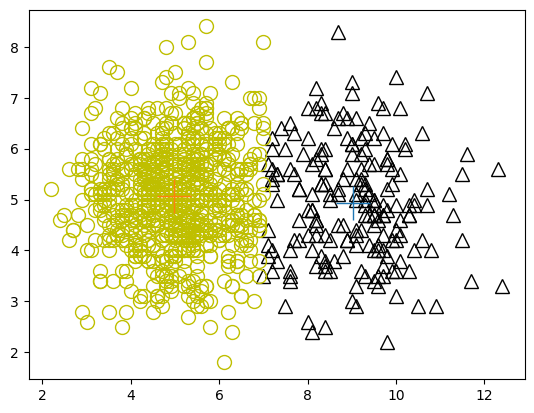

In [13]:
kmeansMB_naive(C12, [1,3], [1,3.1] )

In [14]:
# better implementation
def kmeansMB(C12, c1=[0,0], c2=[10,10], nMBatches=10, animate=True): # nMBatches is number of mini batches that we would like to divide our dataset into 
    if c1 is None: c1 = C12.mean(0) + 2*C12.std(0)
    if c2 is None: c2 = C12.mean(0) - 2*C12.std(0)
    mb = C12.shape[0]//nMBatches
    
    for b in range(nMBatches):
        
        # take a mini-batch  
        C12_ = C12[b*mb :(b+1)*mb,:]

        for i in range(3):
            # first get local clusters and thier centroids
            C1_, C2_ = getClusters(C12_, c1, c2, plot=False) # disable ploting to avoid clutter between local clusters and global clusters
            c1_, c2_ = getCentroids(C1_, C2_)
            
            # now update the centroids by weighted moving average of old and new centroids placing more emphasis on old centroids
            c1 = (c1*(b+1) + c1_)/(b+2) # better than c1 = (c1 + c1_)/2 # because it assigns proportional weights to previous centroids of
            c2 = (c2*(b+1) + c2_)/(b+2) # better than c2 = (c2 + c2_)/2 # so far seen batches and the centroid of the current local cluster
        
        if animate:
            getClusters(C12, c1, c2) # this is unnecessary and is just for animation, we could do it only at the end of the batch loop
        plt.pause(.1)
        clear_output(wait=True)
    
    C1, C2 = getClusters(C12, c1, c2)
    return c1, c2

(array([nan, nan]), array([nan, nan]))

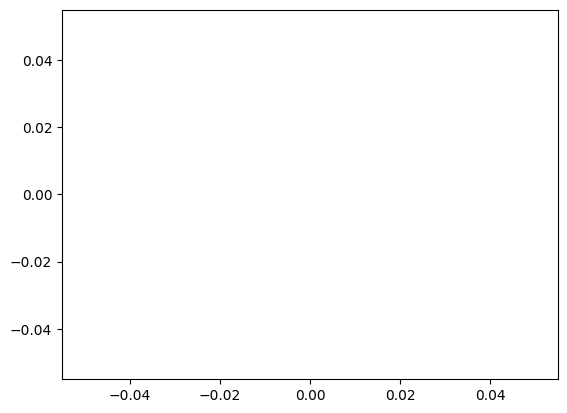

In [15]:
kmeansMB(C12, [1,3], [1,3.1] )
# print(c1, c2)

(array([4.95237329, 5.03277056]), array([8.78606907, 5.02871856]))

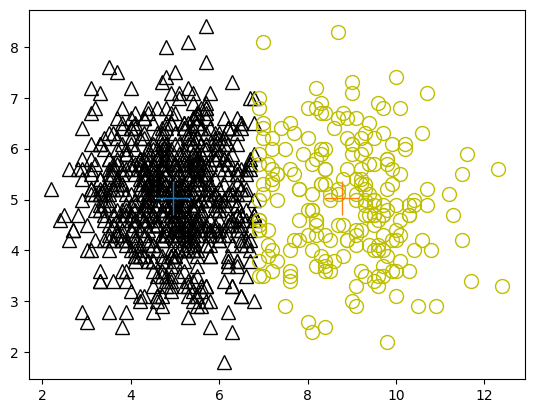

In [16]:
kmeansMB(C12, [1,2])

clusters stabilised


(array([9.00452261, 4.94170854]), array([4.9752809 , 5.07116105]))

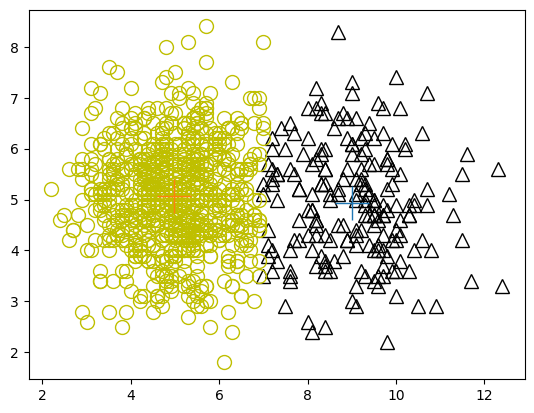

In [17]:
kmeans(C12, [1,3], [1,3.1] )

### Your Turn: Apply the kmeans and MBKmeans on the moon dataset from sklearn

clusters stabilised


(array([3.10883041, 3.10638876]), array([1.04448953, 1.02192414]))

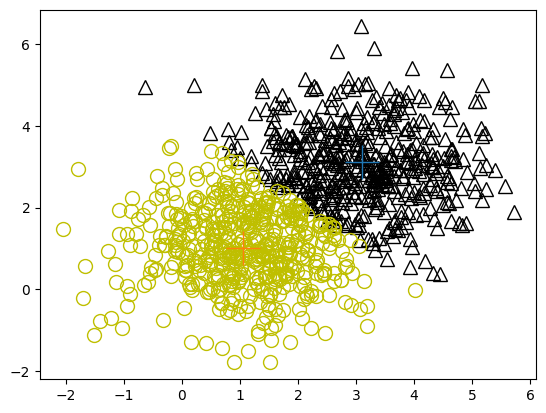

In [18]:
from sklearn.datasets import make_moons, make_circles, make_blobs
X, y = make_blobs(n_samples=1000, centers=[[1,1],[3,3]], random_state=1) # noise=.05
plt.scatter(X[:, 0], X[:, 1], s=10)#, color=y) #colors[y_pred])
kmeans(X)

###  Your Turn: Implement Mini-Batch K-Means++
Take the above code and add an random initialization regime for the centroids that takes into account the distance from current centroids. The idea is to make the centroids as apart from each other as possible. 

# Sample Solution

To initialize centroids in a way that maximizes their distance from each other, you can implement a method known as **k-means++ initialization** or a similar strategy. 

### Key Features:
- The custom initialization ensures centroids are well-separated, reducing the risk of poor clustering results due to random initialization.
- The clustering process is visualized to confirm correct separation of clusters.

Below is the modified code with a custom random initialization regime for centroids:

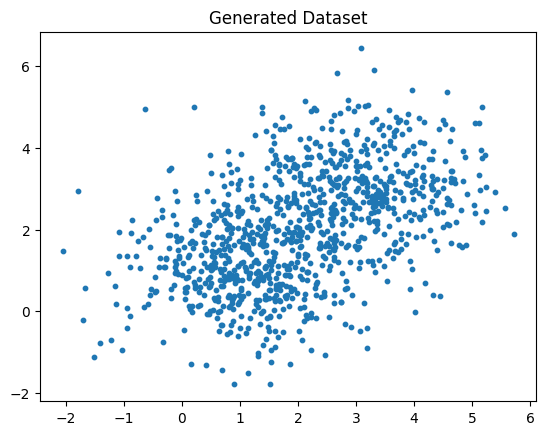

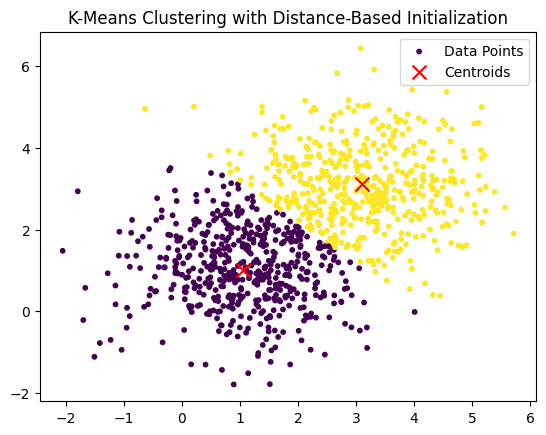

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic dataset
X, y = make_blobs(n_samples=1000, centers=[[1, 1], [3, 3]], random_state=1)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Generated Dataset")
plt.show()

# Custom k-means implementation with distance-based centroid initialization
def kmeans(X, n_clusters=2, max_iter=100):
    """
    Perform k-means clustering with custom centroid initialization.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input dataset.
    - n_clusters: int
        The number of clusters to form.
    - max_iter: int
        Maximum number of iterations.

    Returns:
    - centroids: array-like, shape (n_clusters, n_features)
        Final centroids.
    - labels: array-like, shape (n_samples,)
        Cluster labels for each point.
    """
    # Random initialization regime: Ensure centroids are far apart
    centroids = [X[np.random.choice(range(X.shape[0]))]]  # Start with a random point
    for _ in range(1, n_clusters):
        distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
        next_centroid = X[np.argmax(distances)]  # Select the farthest point as the next centroid
        centroids.append(next_centroid)
    centroids = np.array(centroids)
    
    for _ in range(max_iter):
        # Assign each point to the nearest centroid
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids]).T
        labels = np.argmin(distances, axis=1)
        
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, labels

# Perform clustering
centroids, labels = kmeans(X, n_clusters=2)

# Visualize the result
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', label="Data Points")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label="Centroids")
plt.title("K-Means Clustering with Distance-Based Initialization")
plt.legend()
plt.show()

###  Your Turn: K-Means for K number of Clusters(optional)
Try adapting the above code for multiple clusters 

Try changing the code to use labels instead of sets

# Sample Solution

The following cell provides the adapted code to handle multiple clusters and use labels to represent the clustering results instead of sets:

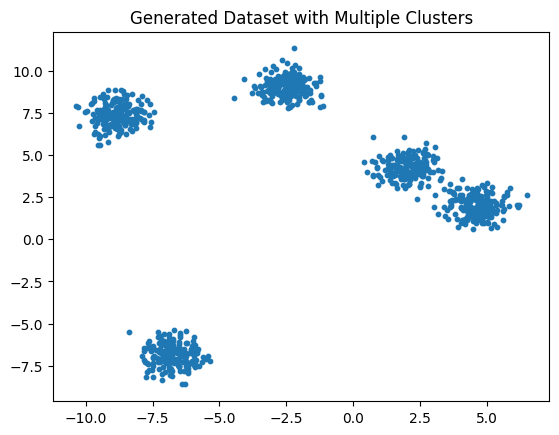

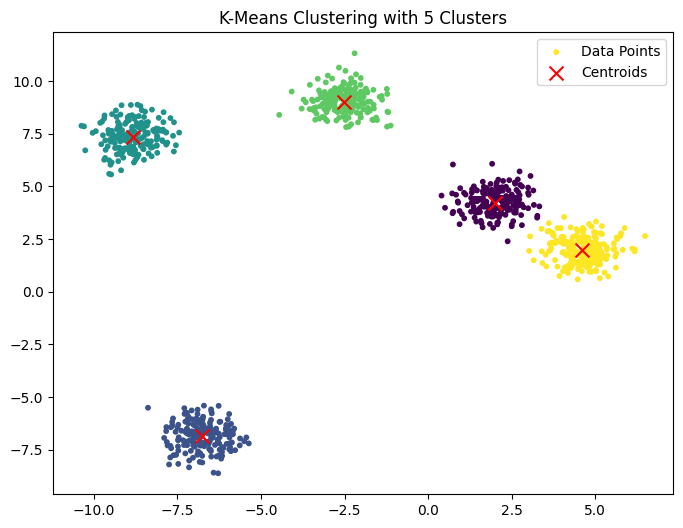

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic dataset with multiple clusters
X, y_true = make_blobs(n_samples=1000, centers=5, cluster_std=0.6, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Generated Dataset with Multiple Clusters")
plt.show()

# Custom k-means implementation with distance-based centroid initialization
def kmeans(X, n_clusters=5, max_iter=100):
    """
    Perform k-means clustering with custom centroid initialization.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input dataset.
    - n_clusters: int
        The number of clusters to form.
    - max_iter: int
        Maximum number of iterations.

    Returns:
    - centroids: array-like, shape (n_clusters, n_features)
        Final centroids.
    - labels: array-like, shape (n_samples,)
        Cluster labels for each point.
    """
    # Distance-based initialization for centroids
    centroids = [X[np.random.choice(range(X.shape[0]))]]  # Start with a random point
    for _ in range(1, n_clusters):
        # Compute distances from the current centroids
        distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
        next_centroid = X[np.argmax(distances)]  # Select the farthest point as the next centroid
        centroids.append(next_centroid)
    centroids = np.array(centroids)
    
    for _ in range(max_iter):
        # Assignment step: Assign each point to the nearest centroid
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in centroids]).T
        labels = np.argmin(distances, axis=1)  # Label is the index of the closest centroid
        
        # Update step: Recompute centroids as the mean of the points in each cluster
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, labels

# Perform clustering
n_clusters = 5
centroids, labels = kmeans(X, n_clusters=n_clusters)

# Visualize the result
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', label="Data Points")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label="Centroids")
plt.title(f"K-Means Clustering with {n_clusters} Clusters")
plt.legend()
plt.show()